In [1]:
import pickle 
import numpy as np
import torch 
import pandas as pd
import rootutils
import json
import os 
import yaml
rootutils.setup_root('/idiap/temp/pvuillecard/projects/gaze_pretrain/notebooks', indicator=".project-root", pythonpath=True)
# plot the results 
import matplotlib.pyplot as plt
from gaze_module.utils.metrics import AngularError
from gaze_module.utils.metrics_utils import spherical2cartesial

In [2]:
def compute_gaze_results(exp_path):
    mode_angular = 'spherical'
    angular_error_all = {}
    with open(exp_path, 'rb') as f:
        exp_results = pickle.load(f)
    print(exp_results['frame_pred'].shape)
    print(exp_results['frame_gt'].shape)
    exp_results['frame_pred'] = exp_results['frame_pred'].view(-1, 2).numpy()
    exp_results['frame_gt'] = exp_results['frame_gt'].view(-1, 2).numpy()
    exp_results['frame_id'] = exp_results['frame_id'].view(-1).numpy()
    exp_results['video_id'] = exp_results['video_id'].view(-1).numpy()
    exp_results['person_id'] = exp_results['person_id'].view(-1).numpy()
    exp_results['data_id'] = exp_results['data_id'].view(-1).numpy()

    with open('/idiap/temp/pvuillecard/projects/face_analyser/datasets/Gaze360/gaze360_image_database.pkl', 'rb') as f:
        image_db_gaze360 = pickle.load(f)
    # include the face information in the prediction 
    for k in image_db_gaze360.keys():
        face_info = image_db_gaze360[k]['other']['person_face_bbox']
        is_face = face_info[0] != -1
        image_db_gaze360[k]['face_info'] = 1 if is_face else 0
        gaze_dir = image_db_gaze360[k]['other']['gaze_dir']
        # compute the angular error with center (0,0,-1)
        angular_error = 180/np.pi*np.arccos(np.dot(gaze_dir, np.array([0, 0, -1])) / (np.linalg.norm(gaze_dir) * np.linalg.norm(np.array([0, 0, -1]))))
        image_db_gaze360[k]['angular_error'] = angular_error

    with open('/idiap/temp/pvuillecard/projects/face_analyser/datasets/GFIE/gfie_image_database.pkl', 'rb') as f:
        image_db_gfie = pickle.load(f)
    for k in image_db_gfie.keys():
        gaze_dir = image_db_gfie[k]['other']['gaze_direction']
        # compute the angular error with center (0,0,-1)
        angular_error = 180/np.pi*np.arccos(np.dot(gaze_dir, np.array([0, 0, -1])) / (np.linalg.norm(gaze_dir) * np.linalg.norm(np.array([0, 0, -1]))))
        image_db_gfie[k]['angular_error'] = angular_error

    with open('/idiap/temp/pvuillecard/projects/face_analyser/datasets/MPSGaze/mpsgaze_image_database.pkl', 'rb') as f:
        image_db_mpsgaze = pickle.load(f)
    for k in image_db_mpsgaze.keys():
        
        gaze_dir = image_db_mpsgaze[k]['other']['gaze_pitch_yaw'][::-1]
        gaze_dir = spherical2cartesial(torch.Tensor(np.array([gaze_dir]))).numpy()[0]
        # compute the angular error with center (0,0,-1)
        angular_error = 180/np.pi*np.arccos(np.dot(gaze_dir, np.array([0, 0, -1])) / (np.linalg.norm(gaze_dir) * np.linalg.norm(np.array([0, 0, -1]))))
        image_db_mpsgaze[k]['angular_error'] = angular_error

        face_info = image_db_mpsgaze[k]['other']['face_bbox_xyxy']
        face_size = face_info[2] - face_info[0]
        if face_size < 30:
            size = None
        elif face_size < 60:
            size = 30
        elif face_size < 90:
            size = 60
        elif face_size < 120:
            size = 90
        elif face_size < 150:
            size = 120
        elif face_size < 180:
            size = 150
        elif face_size < 210:
            size = 180
        elif face_size < 240:
            size = 210
        else :
            size = 240
        image_db_mpsgaze[k]['face_size'] = size

    pred_gaze360 = {}
    for i in range(len(exp_results['frame_id'])):
        if exp_results['data_id'][i] == 1:
            pred_gaze360[f'clip_{exp_results["video_id"][i]:08d}_frame_{exp_results["frame_id"][i]:08d}'] = {
                'frame_pred': exp_results['frame_pred'][i],
                'frame_gt': exp_results['frame_gt'][i]
            }
    if len(pred_gaze360) > 0:
        # gaze 360 error
        angular_error_full = AngularError(mode = mode_angular)
        angular_error_180 = AngularError(mode = mode_angular)
        angular_error_20 = AngularError(mode = mode_angular)
        angular_error_det = AngularError(mode = mode_angular)
    
        for k in pred_gaze360.keys():

            angular_error_full.update(torch.from_numpy(pred_gaze360[k]['frame_gt']).unsqueeze(0),
                                torch.from_numpy(pred_gaze360[k]['frame_pred']).unsqueeze(0))
            if image_db_gaze360[k]['angular_error'] <= 90:
                angular_error_180.update(torch.from_numpy(pred_gaze360[k]['frame_gt']).unsqueeze(0),
                                            torch.from_numpy(pred_gaze360[k]['frame_pred']).unsqueeze(0))
            if image_db_gaze360[k]['angular_error'] <= 20:
                angular_error_20.update(torch.from_numpy(pred_gaze360[k]['frame_gt']).unsqueeze(0),
                                            torch.from_numpy(pred_gaze360[k]['frame_pred']).unsqueeze(0))
            if image_db_gaze360[k]['face_info'] == 1:
                angular_error_det.update(torch.from_numpy(pred_gaze360[k]['frame_gt']).unsqueeze(0),
                                            torch.from_numpy(pred_gaze360[k]['frame_pred']).unsqueeze(0))

        
        angular_error_all["Gaze360_full"] = angular_error_full.compute()
        angular_error_all["Gaze360_180"] = angular_error_180.compute()
        angular_error_all["Gaze360_20"] = angular_error_20.compute()
        angular_error_all["Gaze360_face"] = angular_error_det.compute()
  
    pred_gifie = {}
    for i in range(len(exp_results['frame_id'])):
        if exp_results['data_id'][i] == 2:
            pred_gifie[f'clip_{exp_results["video_id"][i]:08d}_frame_{exp_results["frame_id"][i]:08d}'] = {
                'frame_pred': exp_results['frame_pred'][i],
                'frame_gt': exp_results['frame_gt'][i]
            }
    angular_error_full = AngularError(mode = mode_angular)
    angular_error_180 = AngularError(mode = mode_angular)
    angular_error_20 = AngularError(mode = mode_angular)
    
    if len(pred_gifie) > 0:
        for k in pred_gifie.keys():

            angular_error_full.update(torch.from_numpy(pred_gifie[k]['frame_gt']).unsqueeze(0),
                                torch.from_numpy(pred_gifie[k]['frame_pred']).unsqueeze(0))
            if image_db_gfie[k]['angular_error'] <= 90:
                angular_error_180.update(torch.from_numpy(pred_gifie[k]['frame_gt']).unsqueeze(0),
                                            torch.from_numpy(pred_gifie[k]['frame_pred']).unsqueeze(0))
            if image_db_gfie[k]['angular_error'] <= 20:
                angular_error_20.update(torch.from_numpy(pred_gifie[k]['frame_gt']).unsqueeze(0),
                                            torch.from_numpy(pred_gifie[k]['frame_pred']).unsqueeze(0))
            
        angular_error_all["GFIE_full"] = angular_error_full.compute()
        angular_error_all["GFIE_180"] = angular_error_180.compute()
        angular_error_all["GFIE_20"] = angular_error_20.compute()


    pred_mpsgaze = {}
    for i in range(len(exp_results['frame_id'])):
        if exp_results['data_id'][i] == 3:
            pred_mpsgaze[f'frame_{exp_results["frame_id"][i]:08d}_face_{exp_results["person_id"][i]:08d}'] = {
                'frame_pred': exp_results['frame_pred'][i],
                'frame_gt': exp_results['frame_gt'][i]
            }
    
    angular_error_full = AngularError(mode = mode_angular)
    angular_error = { 30*i: AngularError(mode = mode_angular) for i in range(1, 9)}

    for k in pred_mpsgaze.keys():
        face_size = image_db_mpsgaze[k]['face_size']
        angular_error_full.update(torch.from_numpy(pred_mpsgaze[k]['frame_gt']).unsqueeze(0),
                            torch.from_numpy(pred_mpsgaze[k]['frame_pred']).unsqueeze(0))
        if face_size is not None:
            angular_error[face_size].update(torch.from_numpy(pred_mpsgaze[k]['frame_gt']).unsqueeze(0),
                            torch.from_numpy(pred_mpsgaze[k]['frame_pred']).unsqueeze(0))
    
    angular_error_all[f"MPSGaze_all"] = angular_error_full.compute()
    for k in angular_error.keys():
        angular_error_all[f"MPSGaze_{k}"] = angular_error[k].compute()
    
    # round the results 
    for k in angular_error_all.keys():
        angular_error_all[k] = round(angular_error_all[k].item(),2)
    
    return angular_error_all


In [3]:
path_exp ='/idiap/temp/pvuillecard/projects/gaze_pretrain/logs/train/multiruns/2024-05-20_17-05-53/0/metric/test/prediction_test_gaze_epoch_50.pkl'
results = compute_gaze_results(path_exp)
results = pd.DataFrame([results])
results

torch.Size([77054])
torch.Size([77054])


/idiap/temp/pvuillecard/miniconda3/envs/uniface/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: The ``compute`` method of metric AngularError was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)  # noqa: B028


,Gaze360_full,Gaze360_180,Gaze360_20,Gaze360_face,GFIE_full,GFIE_180,GFIE_20,MPSGaze_all,MPSGaze_30,MPSGaze_60,MPSGaze_90,MPSGaze_120,MPSGaze_150,MPSGaze_180,MPSGaze_210,MPSGaze_240
0,15.44,12.55,10.09,11.99,15.61,14.08,NaN,17.18,19.86,14.33,13.94,11.36,11.0,11.8,8.91,9.15


In [36]:
# pretty print the results 
results

,Gaze360-All,Gaze360-Frontal,GFIE,MPSGaze-30,MPSGaze-60,MPSGaze-90,MPSGaze-120,MPSGaze-150,MPSGaze-180,MPSGaze-210,MPSGaze-240
0,15.44,11.99,15.61,19.860001,14.33,13.94,11.36,11.0,11.8,8.91,9.15


In [39]:
path = '/idiap/temp/pvuillecard/projects/gaze_pretrain/logs/train/multiruns/2024-05-15_22-27-44/10/metric/test/prediction_test_gaze_epoch_50.pkl'
results = compute_gaze_results(path)
results

All 360 angular error is 15.51583480834961
Front facing angular error is 12.275357246398926
All 360 angular error is 15.645090103149414


/idiap/temp/pvuillecard/miniconda3/envs/uniface/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: The ``compute`` method of metric AngularError was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)  # noqa: B028


,Gaze360-All,Gaze360-Frontal,GFIE,MPSGaze-30,MPSGaze-60,MPSGaze-90,MPSGaze-120,MPSGaze-150,MPSGaze-180,MPSGaze-210,MPSGaze-240
0,15.52,12.28,15.65,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [41]:
path = '/idiap/temp/pvuillecard/projects/gaze_pretrain/logs/train/multiruns/2024-05-16_08-52-47/4/metric/test/prediction_test_gaze_epoch_41.pkl'
results = compute_gaze_results(path)
results

All 360 angular error is 14.590807914733887
Front facing angular error is 11.641389846801758
All 360 angular error is nan


/idiap/temp/pvuillecard/miniconda3/envs/uniface/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: The ``compute`` method of metric AngularError was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)  # noqa: B028


,Gaze360-All,Gaze360-Frontal,GFIE,MPSGaze-30,MPSGaze-60,MPSGaze-90,MPSGaze-120,MPSGaze-150,MPSGaze-180,MPSGaze-210,MPSGaze-240
0,14.59,11.64,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
path_exp ='/idiap/temp/pvuillecard/projects/gaze_pretrain/logs/train/multiruns/2024-06-09_00-13-35/0/metric/test/prediction_test_gaze_epoch_50.pkl'
results = compute_gaze_results(path_exp)
results = pd.DataFrame([results])
results

torch.Size([115581])
torch.Size([115581])


RuntimeError: shape '[-1, 2]' is invalid for input of size 115581

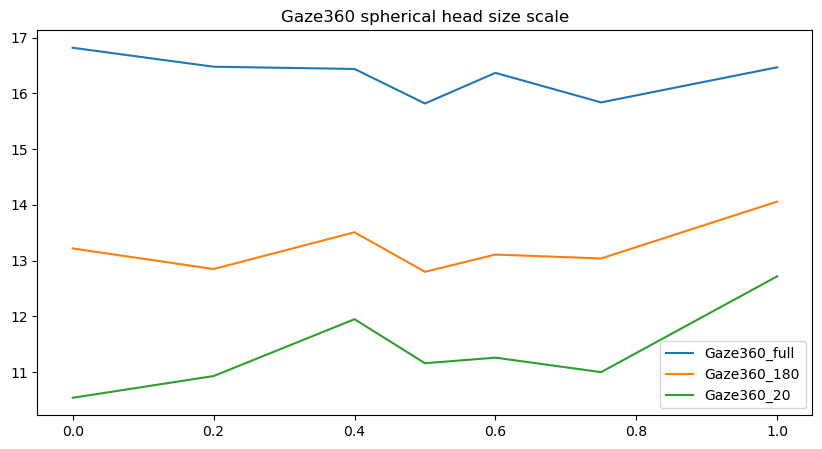

In [8]:
exp_folder = '/idiap/temp/pvuillecard/projects/gaze_pretrain/logs/train/multiruns/'
ratio = []
for j in range(7):
    path_config = f'{exp_folder}2024-06-10_15-27-28/{j}/.hydra/config.yaml'
    with open(path_config, 'r') as f:
        config = yaml.load(f, Loader=yaml.FullLoader)
    ratio.append(config['extras']['bbox_scale_ratio'])

to_plot = {
    'gaze360_full': [],
    'gaze360_180': [],
    'gaze360_20': []
}
for j in range(7):
    path = f'{exp_folder}2024-06-10_15-27-28/{j}/metric/test/angular_error_testdata_epoch_50.json'
    with open(path, 'r') as f:
        results = json.load(f)
    to_plot['gaze360_full'].append(results["Gaze360_full"])
    to_plot['gaze360_180'] += [results["Gaze360_180"]]
    to_plot['gaze360_20'] += [results["Gaze360_20"]]

plt.figure(figsize=(10, 5))
plt.plot(ratio, to_plot['gaze360_full'], label='Gaze360_full')
plt.plot(ratio, to_plot['gaze360_180'], label='Gaze360_180')
plt.plot(ratio, to_plot['gaze360_20'], label='Gaze360_20')
plt.title('Gaze360 spherical head size scale')
plt.legend()
plt.show()

    
    
        
    
        

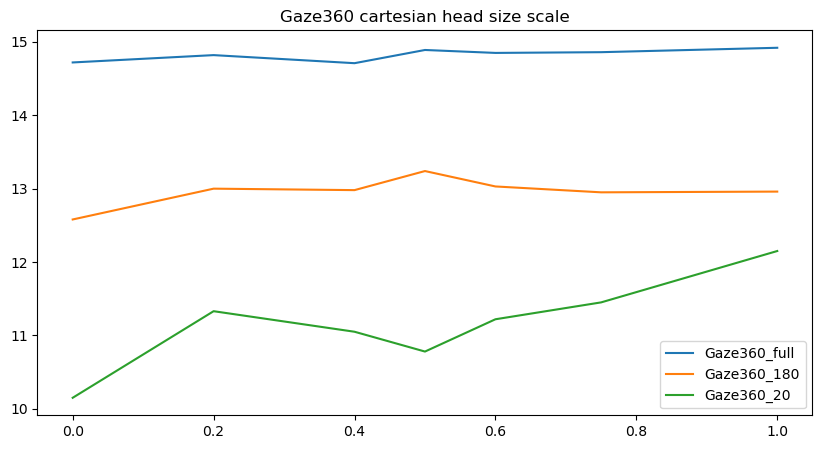

In [11]:
exp_folder = '/idiap/temp/pvuillecard/projects/gaze_pretrain/logs/train/multiruns/'
ratio = []
for j in range(7):
    path_config = f'{exp_folder}2024-06-10_17-46-34/{j}/.hydra/config.yaml'
    with open(path_config, 'r') as f:
        config = yaml.load(f, Loader=yaml.FullLoader)
    ratio.append(config['extras']['bbox_scale_ratio'])

to_plot = {
    'gaze360_full': [],
    'gaze360_180': [],
    'gaze360_20': []
}
for j in range(7):

    path = [ f'{exp_folder}2024-06-10_17-46-34/{j}/metric/test/{name}' for name in os.listdir(f'{exp_folder}2024-06-10_17-46-34/{j}/metric/test') if 'angular_error_testdata' in name ][0]
    with open(path, 'r') as f:
        results = json.load(f)
    to_plot['gaze360_full'].append(results["Gaze360_full"])
    to_plot['gaze360_180'] += [results["Gaze360_180"]]
    to_plot['gaze360_20'] += [results["Gaze360_20"]]

plt.figure(figsize=(10, 5))
plt.plot(ratio, to_plot['gaze360_full'], label='Gaze360_full')
plt.plot(ratio, to_plot['gaze360_180'], label='Gaze360_180')
plt.plot(ratio, to_plot['gaze360_20'], label='Gaze360_20')
plt.title('Gaze360 cartesian head size scale')
plt.legend()
plt.show()